In [1]:
# ==== Librerías principales ====
import os
import json
import numpy as np
import matplotlib.pyplot as plt

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

# ==== Comprobar GPU ====
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando dispositivo:", device, "| Nombre:", torch.cuda.get_device_name(0) if device.type=="cuda" else "CPU")

# Semillas para reproducibilidad
torch.manual_seed(42)
np.random.seed(42)
if device.type == "cuda":
    torch.cuda.manual_seed_all(42)

# ==== Transformaciones ====
data_transforms = {
    "train": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.RandomRotation(10),
        transforms.RandomPerspective(0.1, p=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ]),
    "val": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ]),
    "test": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ]),
}

# ==== Rutas del dataset ====
data_dir = "dataset_dividido_v1"

# ==== Cargar datasets ====
image_datasets = {
    x: datasets.ImageFolder(os.path.join(data_dir, x), transform=data_transforms[x])
    for x in ["train", "val", "test"]
}

# ==== Dataloaders ====
dataloaders = {
    x: DataLoader(image_datasets[x], batch_size=16, shuffle=(x=="train"),
                  num_workers=2, pin_memory=True)
    for x in ["train", "val", "test"]
}

# ==== Clases ====
with open(os.path.join(data_dir, "classes.txt")) as f:
    classes = [line.strip() for line in f]

print("Clases detectadas:", classes)
print("Mapping interno de ImageFolder:", image_datasets["train"].class_to_idx)


Usando dispositivo: cuda | Nombre: NVIDIA GeForce RTX 4050 Laptop GPU
Clases detectadas: ['Condones', 'Cajas de condones', 'Esponjas', 'Botellas de Cloro', 'Placas madre']
Mapping interno de ImageFolder: {'Botellas de Cloro': 0, 'Cajas de condones': 1, 'Condones': 2, 'Esponjas': 3, 'Placas madre': 4}


In [2]:
from torchvision import models

NUM_CLASSES = len(image_datasets["train"].classes)

# Pesos ImageNet
weights = models.VGG19_Weights.IMAGENET1K_V1
vgg = models.vgg19(weights=weights)

# Sustituimos todo el classifier para reducir sobreajuste
# 25088 = 512 * 7 * 7 para input 224x224
vgg.classifier = nn.Sequential(
    nn.Linear(25088, 1024),
    nn.ReLU(inplace=True),
    nn.Dropout(0.4),
    nn.Linear(1024, NUM_CLASSES)
)

vgg = vgg.to(device)
print(vgg.classifier)


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to C:\Users\jhean/.cache\torch\hub\checkpoints\vgg19-dcbb9e9d.pth


100%|██████████| 548M/548M [01:37<00:00, 5.91MB/s] 


Sequential(
  (0): Linear(in_features=25088, out_features=1024, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.4, inplace=False)
  (3): Linear(in_features=1024, out_features=5, bias=True)
)


In [8]:
USE_AMP = (device.type == "cuda")

try:
    # API nueva (algunas builds de PyTorch 2.2+)
    from torch.amp import GradScaler, autocast
    scaler = GradScaler(enabled=USE_AMP)   # 👈 sin device_type
    def autocast_ctx():
        return autocast(device_type="cuda", enabled=USE_AMP)

except Exception:
    # API clásica (torch.cuda.amp)
    from torch.cuda.amp import GradScaler, autocast
    scaler = GradScaler(enabled=USE_AMP)
    def autocast_ctx():
        return autocast(enabled=USE_AMP)


In [10]:
# Congelar TODA la parte convolucional
for p in vgg.features.parameters():
    p.requires_grad = False

# Solo el classifier se entrena
params_head = [p for p in vgg.classifier.parameters() if p.requires_grad]

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.AdamW(params_head, lr=1e-3, weight_decay=5e-4)
EPOCHS_PHASE1 = 8

def run_epoch(model, loader, optimizer=None):
    is_train = optimizer is not None
    model.train(is_train)
    total_loss = total_acc = total = 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)

        with autocast_ctx():
            outputs = model(x)
            loss = criterion(outputs, y)

        if is_train:
            optimizer.zero_grad(set_to_none=True)
            scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            scaler.step(optimizer)
            scaler.update()

        bs = y.size(0)
        total += bs
        total_loss += loss.item() * bs
        total_acc += (outputs.argmax(1) == y).float().sum().item()  # 👈 corregido

    return total_loss/total, total_acc/total

for epoch in range(1, EPOCHS_PHASE1+1):
    tr_loss, tr_acc = run_epoch(vgg, dataloaders["train"], optimizer)
    va_loss, va_acc = run_epoch(vgg, dataloaders["val"], None)
    print(f"[P1 {epoch:02d}/{EPOCHS_PHASE1}] "
          f"train_loss={tr_loss:.4f} val_loss={va_loss:.4f} "
          f"train_acc={tr_acc:.4f} val_acc={va_acc:.4f}")

    if va_loss < best_val - 1e-4:
        best_val = va_loss
        best_state = {k: v.detach().cpu() for k, v in vgg.state_dict().items()}


[P1 01/8] train_loss=0.6936 val_loss=0.6719 train_acc=0.8891 val_acc=0.9028
[P1 02/8] train_loss=0.6599 val_loss=0.6781 train_acc=0.9079 val_acc=0.9060
[P1 03/8] train_loss=0.6366 val_loss=0.6843 train_acc=0.9194 val_acc=0.8997
[P1 04/8] train_loss=0.6797 val_loss=0.7090 train_acc=0.9017 val_acc=0.8746
[P1 05/8] train_loss=0.6436 val_loss=0.6631 train_acc=0.9240 val_acc=0.8840
[P1 06/8] train_loss=0.6278 val_loss=0.6581 train_acc=0.9284 val_acc=0.9122
[P1 07/8] train_loss=0.6649 val_loss=0.6900 train_acc=0.9180 val_acc=0.9028
[P1 08/8] train_loss=0.6411 val_loss=0.6542 train_acc=0.9270 val_acc=0.8966


In [11]:
# Restaurar el mejor estado de la fase 1 por si acaso
if best_state is not None:
    vgg.load_state_dict({k: v.to(device) for k, v in best_state.items()})

# Descongelar el último bloque conv de VGG19
# (ajusta el índice si tu print muestra otra estructura)
for i, m in enumerate(vgg.features):
    if i >= 28:  # último bloque conv + relus
        for p in m.parameters():
            p.requires_grad = True

# Param groups: backbone (lr bajo) + head (lr más alto)
backbone_params = [p for p in vgg.features.parameters() if p.requires_grad]
head_params = [p for p in vgg.classifier.parameters() if p.requires_grad]

optimizer_ft = optim.AdamW([
    {"params": head_params, "lr": 5e-4, "weight_decay": 5e-4},
    {"params": backbone_params, "lr": 1e-4, "weight_decay": 5e-4},
])

scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer_ft, T_max=12)
EPOCHS_PHASE2 = 12

patience = 5
no_improve = 0
best_val = float("inf")
best_state = None

for epoch in range(1, EPOCHS_PHASE2+1):
    tr_loss, tr_acc = run_epoch(vgg, dataloaders["train"], optimizer_ft)
    va_loss, va_acc = run_epoch(vgg, dataloaders["val"], None)
    scheduler.step()

    print(f"[P2 {epoch:02d}/{EPOCHS_PHASE2}] "
          f"train_loss={tr_loss:.4f} val_loss={va_loss:.4f} "
          f"train_acc={tr_acc:.4f} val_acc={va_acc:.4f}")

    if va_loss < best_val - 1e-4:
        best_val = va_loss
        best_state = {k: v.detach().cpu() for k, v in vgg.state_dict().items()}
        no_improve = 0
    else:
        no_improve += 1
        if no_improve >= patience:
            print("Early stopping (P2).")
            break

# Guardar mejor checkpoint
if best_state is not None:
    vgg.load_state_dict({k: v.to(device) for k, v in best_state.items()})
torch.save(vgg.state_dict(), "best_vgg19_tl.pt")
print("Checkpoint guardado: best_vgg19_tl.pt")


[P2 01/12] train_loss=0.6290 val_loss=0.6114 train_acc=0.9228 val_acc=0.9185
[P2 02/12] train_loss=0.5700 val_loss=0.6061 train_acc=0.9521 val_acc=0.9279
[P2 03/12] train_loss=0.5407 val_loss=0.5874 train_acc=0.9615 val_acc=0.9310
[P2 04/12] train_loss=0.5164 val_loss=0.5936 train_acc=0.9689 val_acc=0.9216
[P2 05/12] train_loss=0.4901 val_loss=0.5629 train_acc=0.9771 val_acc=0.9436
[P2 06/12] train_loss=0.4655 val_loss=0.5712 train_acc=0.9878 val_acc=0.9279
[P2 07/12] train_loss=0.4561 val_loss=0.5503 train_acc=0.9892 val_acc=0.9373
[P2 08/12] train_loss=0.4482 val_loss=0.5485 train_acc=0.9900 val_acc=0.9373
[P2 09/12] train_loss=0.4420 val_loss=0.5464 train_acc=0.9902 val_acc=0.9436
[P2 10/12] train_loss=0.4392 val_loss=0.5384 train_acc=0.9924 val_acc=0.9404
[P2 11/12] train_loss=0.4351 val_loss=0.5445 train_acc=0.9912 val_acc=0.9404
[P2 12/12] train_loss=0.4356 val_loss=0.5435 train_acc=0.9924 val_acc=0.9404
Checkpoint guardado: best_vgg19_tl.pt


TEST Accuracy (VGG19 TL/FT): 0.9158

== Classification report ==
                   precision    recall  f1-score   support

Botellas de Cloro     0.9453    0.9744    0.9596       195
Cajas de condones     0.8840    0.9088    0.8962       285
         Condones     0.8232    0.8385    0.8308       161
         Esponjas     0.9710    0.8933    0.9306       150
     Placas madre     0.9930    0.9592    0.9758       147

         accuracy                         0.9158       938
        macro avg     0.9233    0.9148    0.9186       938
     weighted avg     0.9173    0.9158    0.9161       938

Macro-F1: 0.9185786128519693


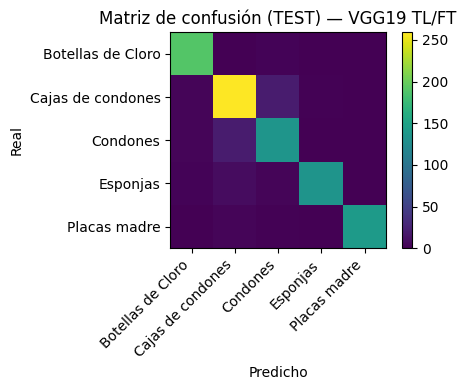

In [12]:
# Evaluación final
vgg.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for x, y in dataloaders["test"]:
        x = x.to(device)
        with autocast_ctx():
            logits = vgg(x)
        all_preds.extend(logits.argmax(1).cpu().numpy())
        all_labels.extend(y.numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
acc = (all_preds == all_labels).mean()
print(f"TEST Accuracy (VGG19 TL/FT): {acc:.4f}")

try:
    from sklearn.metrics import classification_report, confusion_matrix, f1_score
    print("\n== Classification report ==")
    print(classification_report(all_labels, all_preds, target_names=image_datasets["test"].classes, digits=4))
    print("Macro-F1:", f1_score(all_labels, all_preds, average="macro"))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(5,4))
    plt.imshow(cm, interpolation="nearest")
    plt.title("Matriz de confusión (TEST) — VGG19 TL/FT")
    plt.colorbar()
    ticks = np.arange(len(image_datasets["test"].classes))
    plt.xticks(ticks, image_datasets["test"].classes, rotation=45, ha="right")
    plt.yticks(ticks, image_datasets["test"].classes)
    plt.xlabel("Predicho"); plt.ylabel("Real")
    plt.tight_layout(); plt.show()
except Exception as e:
    print("sklearn no disponible:", e)
